# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot 
import seaborn as sns
from wordcloud import WordCloud

# Importing necessary modules for model evaluation and preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

# Importing GridSearchCV for hyperparameter tuning and mean_squared_error for model evaluation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# package that will help us to save tough models, this will allow us to run all notebook quickly 
import pickle as pk
import pickle
from math import sqrt
import json
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
#pip install wordcloud

# Read CSVs

Datasets are available on the link in readME. Change the paths as needed.

In [3]:
path_movies ='../Datasets/movies.csv'
path_ratings = '../Datasets/ratings.csv' 
path_tags = '../Datasets/tags.csv' 

movies = pd.read_csv(path_movies)
ratings = pd.read_csv(path_ratings)
tags = pd.read_csv(path_tags)

# Movies Dataset

## Data Understanding

Basic stats of Movies Dataset. No null falues were found, so no missing data handling was made.

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.dtypes

movieId     int64
title      object
genres     object
dtype: object

In [6]:
movies.shape

(62423, 3)

In [7]:
movies.describe()

,movieId
count,62423.000000
mean,122220.387646
std,63264.744844
min,1.000000
25%,82146.500000
50%,138022.000000
75%,173222.000000
max,209171.000000


In [8]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [9]:
movies.nunique()

movieId    62423
title      62325
genres      1639
dtype: int64

In [10]:
movies.duplicated().sum()

0

In [11]:
movies['title'].value_counts()

title
The Void (2016)                                2
Seven Years Bad Luck (1921)                    2
Clear History (2013)                           2
Enron: The Smartest Guys in the Room (2005)    2
Deranged (2012)                                2
                                              ..
$ellebrity (Sellebrity) (2012)                 1
Macabre (Macabro) (1980)                       1
Punk's Dead: SLC Punk! 2 (2014)                1
Chinese Hercules (1973)                        1
Women of Devil's Island (1962)                 1
Name: count, Length: 62325, dtype: int64

In [12]:
movies.isnull().sum()

movieId    0
title      0
genres     0
dtype: int64

In [13]:
movies.isna().sum()

movieId    0
title      0
genres     0
dtype: int64

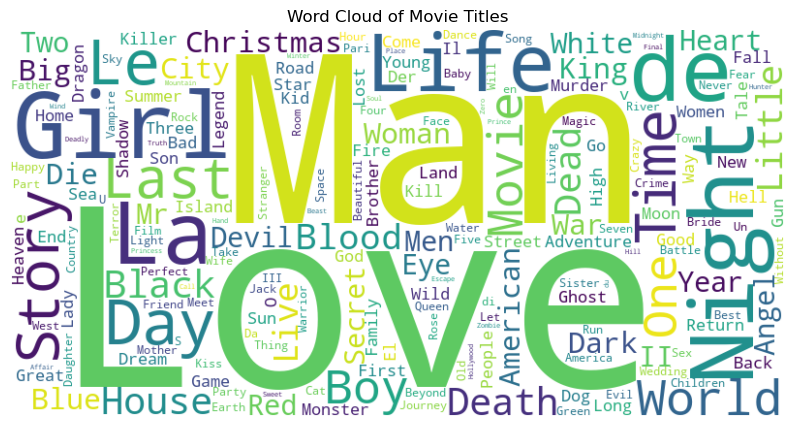

In [14]:
text = ' '.join(movies['title'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles')
plt.show()

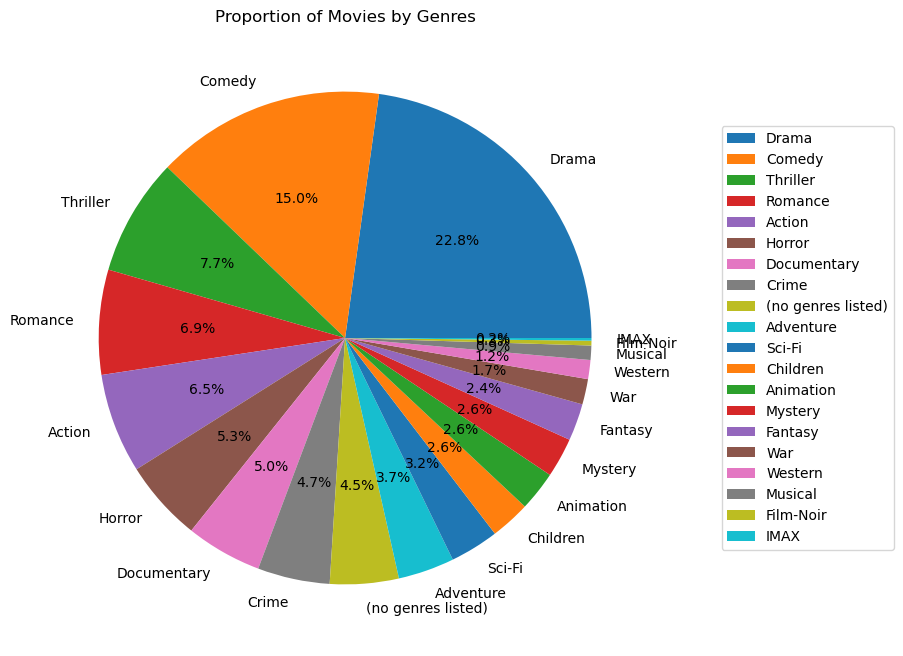

In [15]:
genres_count = movies['genres'].str.split('|', expand=True).stack().value_counts()

plt.figure(figsize=(10, 8))
genres_count.plot(kind='pie', autopct='%1.1f%%')
plt.legend(genres_count.index, loc="center left", bbox_to_anchor=(1.1, 0, 0.5, 1))
plt.title('Proportion of Movies by Genres')
plt.ylabel('')
plt.show()

# Data Preparation

## Genre splitting

In this process we will slice the genre column and do dummy encoding in it. This will enable us to work with the genres as if those are numerical values. 

In the code below 3 actions were done:
- Slicing of genres;
- Creation of genre_count column;
- Moving genre_count to the front of the new section.

In [16]:
# Separating genres to count them.
movie_genres = movies['genres'].str.get_dummies('|')
movie_genres.drop(columns=["(no genres listed)"], inplace=True)

# Creating the genre_count column, that calculate how many genres the movie has and gives a numerical value.
movie_genres['genre_count'] = movie_genres.iloc[:, 0:19].astype(bool).sum(axis=1)

# Moving the column to the front.
genre_count_column = movie_genres.pop('genre_count')
movie_genres.insert(0, 'genre_count', genre_count_column)
movie_genres.head()

,genre_count,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,5,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,3,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,3,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Below we just are going to merge these new columns to the main dataset:

In [17]:
# merge with original dataset.
movies_encoded = pd.concat([movies, movie_genres], axis=1)
movies_encoded.head()

,movieId,title,genres,genre_count,Action,Adventure,Animation,Children,Comedy,Crime,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,3,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,2,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Year Column addition

Another numerical value we can insert in this dataset is the year, because all movie names contain their year in parenthesis. In this code below we:

- Extracted year values;
- Filled NA values with 0 (in case some movies don't have the Year value in the correct format/ don't have the year value);
- Moved the column to the third position.

In [18]:
# Extraction of the year, and na filling
movies_encoded['year'] = movies_encoded['title'].str.extract(r'\((\d{4})\)')
movies_encoded['year'] = movies_encoded['year'].fillna(0).astype('int64')

# moving column around to the front
year_column = movies_encoded.pop('year')
movies_encoded.insert(2, 'year', year_column)

movies_encoded.head()

,movieId,title,year,genres,genre_count,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),1995,Adventure|Animation|Children|Comedy|Fantasy,5,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),1995,Adventure|Children|Fantasy,3,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),1995,Comedy|Romance,2,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),1995,Comedy|Drama|Romance,3,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),1995,Comedy,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


# Data Understanding about genres 

### Movie with the highest number of genres

In [19]:
print("The movie with the most number of genres contains:", movies_encoded.genre_count.max(), "genres")
print("The movie moth most genres is:")
movies_max = movies_encoded[movies_encoded['genre_count'] == 10]
movies_max

The movie with the most number of genres contains: 10 genres
The movie moth most genres is:


,movieId,title,year,genres,genre_count,Action,Adventure,Animation,Children,Comedy,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
15389,81132,Rubber (2010),2010,Action|Adventure|Comedy|Crime|Drama|Film-Noir|...,10,1,1,0,0,1,...,1,1,0,0,1,0,0,1,0,1


In [20]:
average_genre_count = round(movies_encoded['genre_count'].mean(), 2)
average_year = int(movies_encoded['year'].mean())
year_counts = movies_encoded['year'].value_counts().reset_index().head(10)

print("The average number of genres for each movie is: {:.2f}\nThe average year is: {}\nAnd these are the top 10 years for movies in our system:".format(average_genre_count, average_year))
year_counts

The average number of genres for each movie is: 1.72
The average year is: 1978
And these are the top 10 years for movies in our system:


,year,count
0,2015,2513
1,2016,2488
2,2014,2406
3,2017,2374
4,2013,2173
5,2018,2034
6,2012,1978
7,2011,1838
8,2009,1724
9,2010,1691


# EDA

## Genre

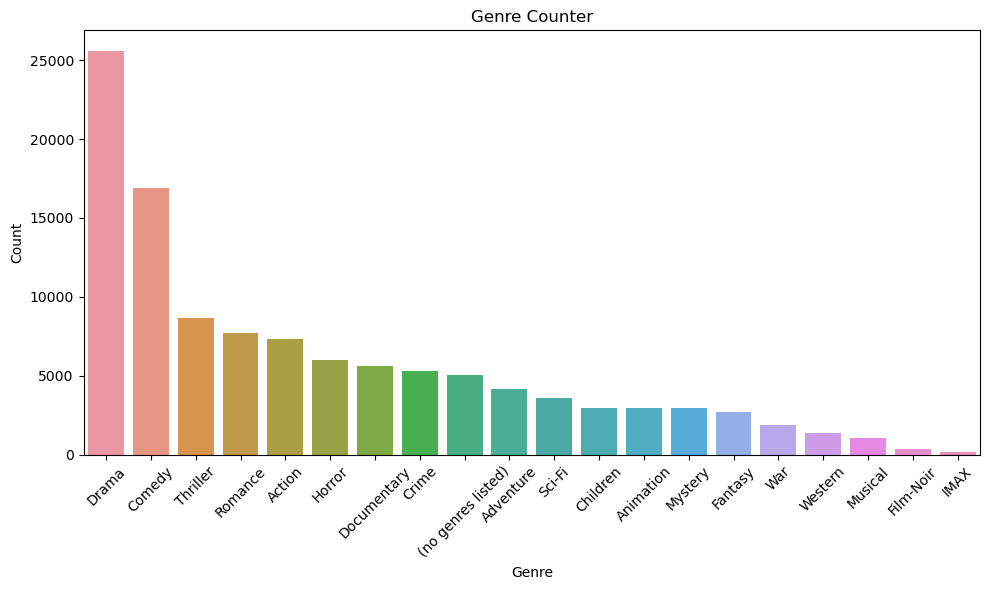

In [21]:
genres_count = movies_encoded['genres'].str.split('|', expand=True).stack().value_counts().reset_index()
genres_count.columns = ['genres', 'count']

plt.figure(figsize=(10, 6))
sns.barplot(x='genres', y='count', data=genres_count)
plt.title('Genre Counter')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Year

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


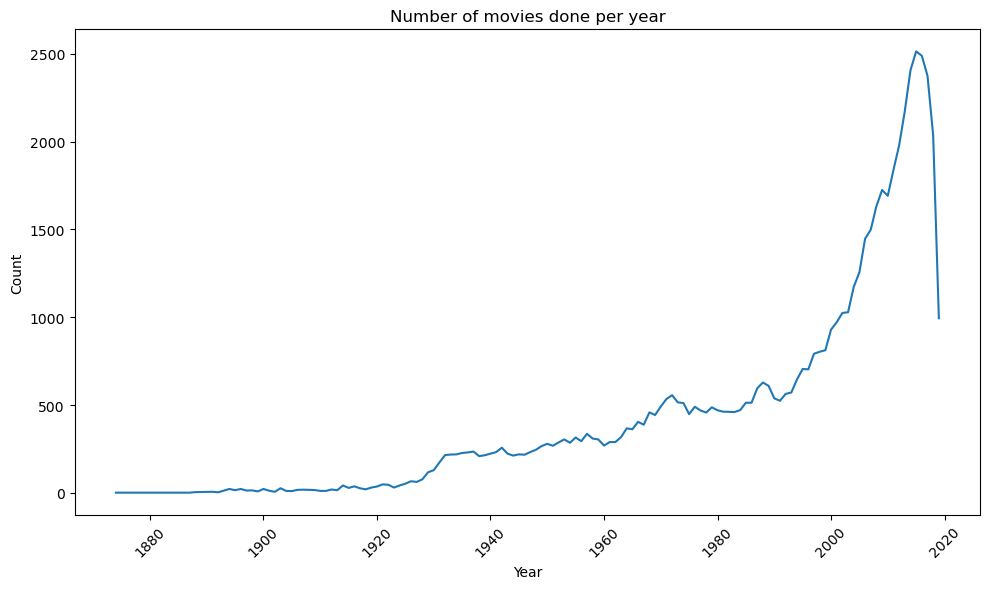

In [22]:
year_counts = movies_encoded['year'].replace(0, np.NaN)
year_counts = year_counts.dropna()
year_counts = year_counts.value_counts().reset_index()
year_counts

plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='count', data=year_counts)
plt.title('Number of movies done per year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

# Ratings dataset

## Data Understanding

In [23]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [24]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [25]:
ratings.shape

(25000095, 4)

In [26]:
ratings.duplicated().sum()

0

In [27]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [28]:
ratings.isnull().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

In [29]:
ratings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

array([[<Axes: title={'center': 'userId'}>,
        <Axes: title={'center': 'movieId'}>],
       [<Axes: title={'center': 'rating'}>,
        <Axes: title={'center': 'timestamp'}>]], dtype=object)

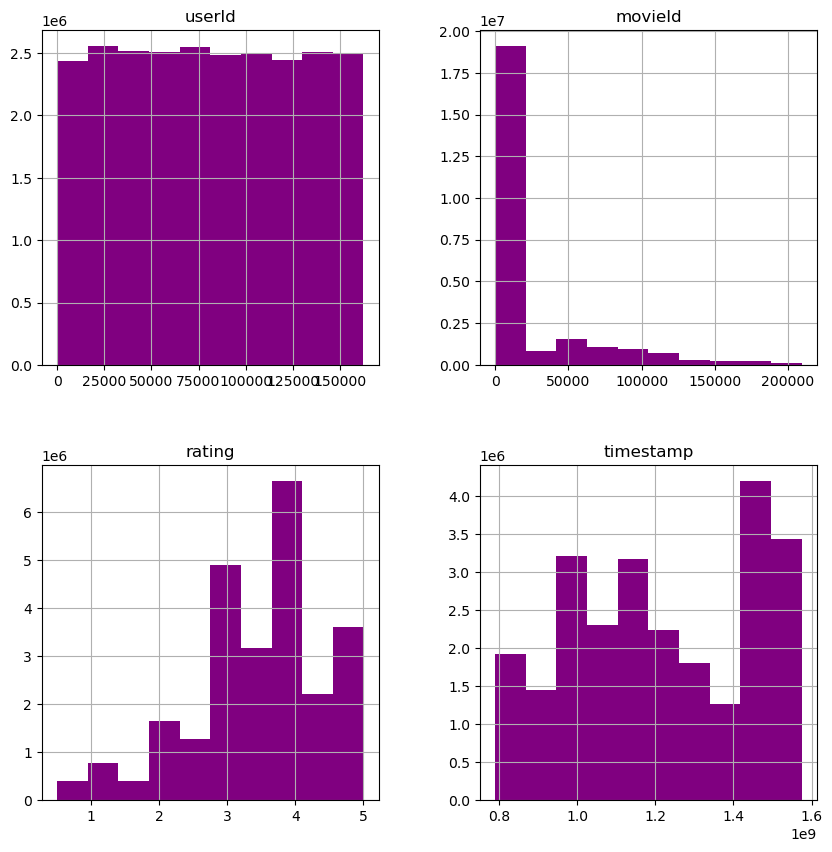

In [30]:
ratings.hist(figsize = (10,10), color="#800080")

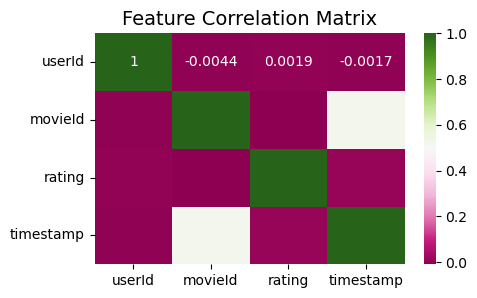

In [31]:
plt.figure(figsize=(5,3))
sns.heatmap(ratings.corr(), annot=True, cmap='PiYG')
plt.title("Feature Correlation Matrix",fontsize=14)
plt.show()

# Data preparation for Ratings

Since there are no missing values or duplicates, we can go on excluding the 'timestamp' column (it is not necessary for what we need).

In [32]:
ratings.drop(columns="timestamp",inplace = True)

# Merging datasets

To move forward we will use one dataset only, so we need to merge Movies_Encoded and Ratings. We will name this Merged, as in a merged dataframe.

In [33]:
# Merging movies_encoded and ratings dataframes 
merged = ratings.merge(movies_encoded,on="movieId")
merged.head()

,userId,movieId,rating,title,year,genres,genre_count,Action,Adventure,Animation,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,296,5.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,3,296,5.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,4,296,4.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,5,296,4.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,7,296,4.0,Pulp Fiction (1994),1994,Comedy|Crime|Drama|Thriller,4,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [34]:
# Dropping genres because we will not need it further
merged.drop(columns="genres",inplace = True)

In [35]:
merged.shape

(25000095, 25)

In [36]:
merged.isnull().sum()

userId         0
movieId        0
rating         0
title          0
year           0
genre_count    0
Action         0
Adventure      0
Animation      0
Children       0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
IMAX           0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

In [37]:
merged.isna().sum()

userId         0
movieId        0
rating         0
title          0
year           0
genre_count    0
Action         0
Adventure      0
Animation      0
Children       0
Comedy         0
Crime          0
Documentary    0
Drama          0
Fantasy        0
Film-Noir      0
Horror         0
IMAX           0
Musical        0
Mystery        0
Romance        0
Sci-Fi         0
Thriller       0
War            0
Western        0
dtype: int64

In [38]:
merged.duplicated().sum()

0

# Data preparation for Modelling

In [39]:
# take sample of 100k records from merged dataset
merged_sample = merged.sample(100000)

In [40]:
# rating is a float number, to pass it to model, we need integer value
encoder = {
          0.5: 1,
          1 : 2,
          1.5: 3,
          2:4,
          2.5 : 5,
          3:6,
          3.5:7,
          4:8,
          4.5:9,
          5:10
           }
merged_sample["rating"] = merged_sample["rating"].map(encoder)

In [41]:
# select predictor columns
columns_X = merged_sample.columns.to_list()
columns_X.remove("rating")
columns_X.remove("title")
columns_X  

['userId',
 'movieId',
 'year',
 'genre_count',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [42]:
# declare X and y values 
X = merged_sample[columns_X]
y = merged_sample["rating"]

In [43]:
# select few algorithms for comparison 
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('DT', DecisionTreeRegressor()))
models.append(("RF", RandomForestClassifier()))
models.append(('NB', GaussianNB()))

In [44]:
# split data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.3,  
                                   shuffle=True) 

In [45]:
# scale training ans testing set 
scaler = StandardScaler()  
scaler.fit(X_train)  
X_train_scaled = scaler.transform(X_train)  
X_test_scaled = scaler.transform(X_test) 

# Models Cross Validation

Here we will perform Stratified K-Fold Cross Validation to see which model performs the best.

In [46]:
results = []
names = []
for name, model in models:
  kfold = StratifiedKFold(n_splits=5, random_state=104, shuffle=True)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_root_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  print('%s: %f (%f)' % (name, (cv_results.mean() * -1), cv_results.std())) 

LDA: 2.265251 (0.007254)
DT: 2.773495 (0.015979)
RF: 2.673022 (0.017988)
NB: 2.293473 (0.013425)


## Comparison Box Plot

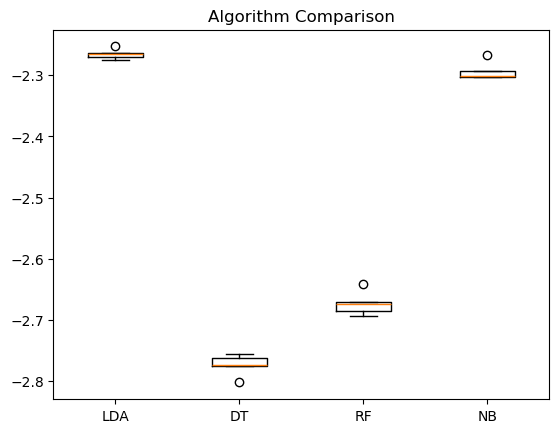

In [47]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show() 

In [48]:
# free up memory 
models = None

To optimise, we can use Grid Search, that is a technique to tune hyperparameters of a ML model.

In [49]:
# we can see that LDA performed the best, we can now try to optimise it with grid search
parameters = {
    'n_components': [None, 1, 2, 3],
    'tol': [1e-4, 1e-3, 1e-2],
    'store_covariance': [True, False],
}

# Initialize LDA
lda = LinearDiscriminantAnalysis()

# Perform grid search
grid_search = GridSearchCV(lda, parameters, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'n_components': [None, 1, 2, 3],
                         'store_covariance': [True, False],
                         'tol': [0.0001, 0.001, 0.01]})

At this point, we have chosen and optimised one of models available in sklearn package. In the next part, we will compare it to algorithm obtained from the Suprise package, which was influenced by SVD algorithm.

# SVD Algorithm

In [50]:
class SVD():

    def __init__(self, n_factors=100, n_epochs=20, biased=True, init_mean=0,
                 init_std_dev=.1, lr_all=.005,
                 reg_all=.02, lr_bu=None, lr_bi=None, lr_pu=None, lr_qi=None,
                 reg_bu=None, reg_bi=None, reg_pu=None, reg_qi=None,
                 random_state=None, verbose=False):

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.biased = biased
        self.init_mean = init_mean
        self.init_std_dev = init_std_dev
        self.lr_bu = lr_bu if lr_bu is not None else lr_all
        self.lr_bi = lr_bi if lr_bi is not None else lr_all
        self.lr_pu = lr_pu if lr_pu is not None else lr_all
        self.lr_qi = lr_qi if lr_qi is not None else lr_all
        self.reg_bu = reg_bu if reg_bu is not None else reg_all
        self.reg_bi = reg_bi if reg_bi is not None else reg_all
        self.reg_pu = reg_pu if reg_pu is not None else reg_all
        self.reg_qi = reg_qi if reg_qi is not None else reg_all
        self.random_state = random_state
        self.verbose = verbose


    def fit(self, X, y):
      
        data = X.join(y)
        self.n_users = data["userId"].unique().max() + 1
        self.n_items = data["movieId"].unique().max() + 1
        self.global_mean = y.mean()
        self.dataset = data
        self.train_data = data.to_numpy()

        self.sgd(data)

        return self

    def sgd(self, data):
      
        rng =  np.random.RandomState()

        # user biases
        bu = np.zeros(self.n_users, dtype=np.double)
        # item biases
        bi = np.zeros(self.n_items, dtype=np.double)
        # user factors
        pu = rng.normal(self.init_mean, self.init_std_dev, size=(self.n_users, self.n_factors))
        # item factors
        qi = rng.normal(self.init_mean, self.init_std_dev, size=(self.n_items, self.n_factors))

        # u, i, f
        n_factors = self.n_factors
        biased = self.biased

        # r, err, dot, puf, qif
        global_mean = self.global_mean

        lr_bu = self.lr_bu
        lr_bi = self.lr_bi
        lr_pu = self.lr_pu
        lr_qi = self.lr_qi

        reg_bu = self.reg_bu
        reg_bi = self.reg_bi
        reg_pu = self.reg_pu
        reg_qi = self.reg_qi

        if not biased:
            global_mean = 0

        for current_epoch in range(self.n_epochs):
            if self.verbose:
                print("Processing epoch {}".format(current_epoch))

            for  u, i, r in self.train_data:
                # compute current error
                u = int(u)
                i = int(i)
                r = int(r)
                dot = 0  # <q_i, p_u>
                for f in range(n_factors):
                    dot += qi[i, f] * pu[u, f]
                err = r - (global_mean + bu[u] + bi[i] + dot)

                # update biases
                if biased:
                    bu[u] += lr_bu * (err - reg_bu * bu[u])
                    bi[i] += lr_bi * (err - reg_bi * bi[i])

                # update factors
                for f in range(n_factors):
                    puf = pu[u, f]
                    qif = qi[i, f]
                    pu[u, f] += lr_pu * (err * qif - reg_pu * puf)
                    qi[i, f] += lr_qi * (err * puf - reg_qi * qif)

        self.bu = np.asarray(bu)
        self.bi = np.asarray(bi)
        self.pu = np.asarray(pu)
        self.qi = np.asarray(qi)
    
    def predict(self,X):
      
        y= []
        X = X.to_numpy()
        for u, i in X:
            y.append(self.estimate(u,i))
        return y

        

    def estimate(self, u, i):

        # known_user = u in self.dataset["userId"].values
        # known_item = i in self.dataset["movieId"].values
        known_user = False
        known_item = False
        try: 
            known_user = self.bu[u] != None
        except: 
            pass
        try:
            known_item = self.bi[i] != None
        except:
            pass
        
        if self.biased:
            est = self.global_mean

            if known_user:
                est += self.bu[u]

            if known_item:
                est += self.bi[i]

            if known_user and known_item:
                est += np.dot(self.qi[i], self.pu[u])

        else:
            if known_user and known_item:
                est = np.dot(self.qi[i], self.pu[u])
            else:
                raise KeyError('User and item are unknown.')

        return est

# Test and Validation

In [51]:
# defining number of users for test comparison between custom svd and from sklearn
sample_size = [10000, 15000, 30000, 45000, 60000]

In [52]:
# results
algo_sklearn_rmse = []
algo_svd_rmse = []

In [53]:
# try and see if sklearn-algo test results are available 
try: 
  with open('../results/algo_sklearn_rmse.txt', 'r') as file:
    results = file.readline()
    algo_sklearn_rmse = json.loads(results)
except:
  pass

algo_sklearn_rmse

[2.3425769286549945,
 2.35055548990257,
 2.2933478681709945,
 2.2902369277402688,
 2.2633308787419186,
 2.2626680416416955,
 2.2917242417009946,
 2.3196024563609074,
 2.2775230209837862,
 2.2879879564562593,
 2.2960110336552537,
 2.2881336402307353,
 2.2558319480355307,
 2.272019822553068,
 2.2804482990071153,
 2.229872941073848,
 2.2291503114664812,
 2.227105745132009,
 2.241510733940476,
 2.2520114465862635]

In [54]:
# try and see if svd-algo test results are available 
try: 
  with open('../results/algo_svd_rmse.txt', 'r') as file:
    results = file.readline()
    algo_svd_rmse = json.loads(results)
except:
  pass

algo_svd_rmse

[2.0972767214259664,
 2.0317441172867183,
 2.024771974793931,
 2.0179876383358613,
 1.9939544299828276,
 2.0551561771281923,
 2.048456944831293,
 2.0555370721048267,
 2.00011272771301,
 1.9964765402670848,
 2.0935314645213654,
 2.0837561075068387,
 2.030628349309747,
 2.0175042279761497,
 2.0054881475394097,
 2.052974107995737,
 2.069070540126757,
 2.024614195361767,
 1.9927154546820092,
 1.9793990449689827]

In [ ]:
for size in sample_size:
    sample_data = merged_sample[:size]
    X = sample_data[columns_X]
    y = sample_data["rating"]
    X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                   random_state=104,  
                                   test_size=0.3,  
                                   shuffle=True) 


    model_sklearn = LinearDiscriminantAnalysis(**grid_search.best_params_)
    m1_pred = model_sklearn.fit(X_train,y_train).predict(X_test)
    mse_1 = mean_squared_error(y_test, m1_pred)
    algo_sklearn_rmse.append(sqrt(mse_1))

    X_test = X_test[["userId","movieId"]]
    X_train = X_train[["userId","movieId"]]
    model_svd = SVD()
    m2_pred = model_svd.fit(X_train,y_train).predict(X_test)
    mse_2 = mean_squared_error(y_test, m2_pred)
    algo_svd_rmse.append(sqrt(mse_2))

Saving results:

In [ ]:
with open('../results/algo_svd_rmse.txt', 'w') as file:
    json.dump(algo_svd_rmse, file)
with open('../results/algo_sklearn_rmse.txt', 'w') as file:
    json.dump(algo_sklearn_rmse, file)

In [ ]:
print(algo_sklearn_rmse)
print(algo_svd_rmse)

In [ ]:
# plt.figure(figsize=(10, 6))

# plt.plot(sample_size, algo_sklearn_rmse, marker='o', label='Algorithm LDA')
# plt.plot(sample_size, algo_svd_rmse, marker='o', label='Algorithm SVD')

# plt.xlabel('Data Size')
# plt.ylabel('Root Mean Squared Error (RMSE)')
# plt.title('Comparison of Root Mean Squared Error between Algorithms across Different Data Sizes')
# plt.legend()
# plt.grid(True)

# plt.show()

In [ ]:
print(len(sample_size), len(algo_sklearn_rmse), len(algo_svd_rmse))

## Further testing with Custom SVD Algorithm

In [ ]:
svd_test_sample_sizes = [100000, 150000, 200000, 250000, 300000]

In [ ]:
svd_test_results = []

In [ ]:
# check if svd test results are available 
try: 
  with open('../results/svd_test_results.txt', 'r') as file:
    results = file.readline()
    svd_test_results = json.loads(results)
except:
  pass

svd_test_results

In [ ]:
#run tests only if results are not available 
if len(svd_test_results) == 0:
  for n in svd_test_sample_sizes:
    sample = ratings[:n]
    X = sample[["userId","movieId"]]
    y = sample["rating"]
    X_train, X_test, y_train, y_test = train_test_split(X,y , 
                                    random_state=104,  
                                    test_size=0.3,  
                                    shuffle=True) 
    
    # try to load pre-trained model, random state will assure that model  is trained and tested on the same data 
    filename = '../models/model_test_' + str(n) + '.sav'
    model = None
    try:
      model = pickle.load(open(filename, 'rb'))
    except:
      print("Pretrained model not found: " + 'model_test_' + str(n))
      pass
    # only train model if not available
    if model == None:
      model = SVD()
      model = model.fit(X_train,y_train)
      
    y_pred_svd = model.predict(X_test)
    mse_svd = mean_squared_error(y_test, y_pred_svd)
    svd_test_results.append(sqrt(mse_svd))
    # save model 
    pickle.dump(model, open(filename, 'wb'))

In [ ]:
# save results from svd test  
with open('../results/svd_test_results.txt', 'w') as filehandle:
    json.dump(svd_test_results, filehandle)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(svd_test_sample_sizes, svd_test_results, marker='o', label='SVD Custom Algorithm')

plt.xlabel('Sample Size')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.title('Performance of SVD algorithm with increasing data sample size')
plt.legend()
plt.grid(True)

plt.show()

# Training Final Model

With this algorithm the more Movie and User data we provide, e.g. rating score, the better it will perform. This happens because it adjusts biases from user and movie and let us filter the dataframe for movies that were rated more than 10000 times. This will help with time required to train the model and will assure that model has enough data to perform well.

## Data Preparation

In [ ]:
#filter for movies that were rated more than 10k times 
movie_ratings_count = ratings['movieId'].value_counts().reset_index()
ids_10k = movie_ratings_count[movie_ratings_count["count"] > 10000]
ids_10k.info()
ids = ids_10k["movieId"].values

In [ ]:
# filter original dataframe for rows that contain selected movieIds 
ratings_final = ratings[ratings['movieId'].isin(ids)]

After filtering we have 588 movies in our final dataset.

In [ ]:
ratings_final["movieId"].nunique()

In [ ]:
movies = None
ratings = None

We have reduced size of the dataframe by half.

In [ ]:
ratings_final.info()

In [ ]:
# ratings_final.drop(columns="timestamp", inplace=True)?

In [ ]:
filename = "../datasets/ratings_final.csv"
pd.DataFrame(data=ratings_final).to_csv(filename, sep=',', index=False, encoding='utf-8')

## Data Preparation for Modeling

In [ ]:
X = ratings_final[["userId", "movieId"]]
y = ratings_final["rating"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
X = None
y = None

Load trained model if exists:

In [ ]:
filename = '../models/final_model.sav'
final_model = None
try:
  final_model = pickle.load(open(filename, 'rb'))
except:
  print("Final model not found")

## Training and Validating Final Model

In [ ]:
filename = '../models/final_model.sav'
if final_model is None:
  final_model = SVD(n_factors=1, n_epochs=1)
  final_model.fit(X_train, y_train)
# after trained, save final model 
pickle.dump(final_model, open(filename, 'wb'))

In [ ]:
y_pred_final = None
y_train_predict_final = None

Test prediction against testing set

In [ ]:
# import X_test prediction results if available 
try: 
  with open('../results/final_results_test.txt', 'r') as file:
    results = file.readline()
    y_pred_final = json.loads(results)
except:
  print("Results not found")
  pass

In [ ]:
if y_pred_final == None:
  y_pred_final = final_model.predict(X_test)

In [ ]:
with open('../results/final_results_test.txt', 'w') as file:
    json.dump(y_pred_final, file)

Test against training set

In [ ]:
# import X_train prediction results if available
try: 
  with open('../results/final_results_train.txt', 'r') as file:
    results = file.readline()
    y_train_predict_final = json.loads(results)
except:
  print("Results not found")
  pass

In [ ]:
if y_train_predict_final == None:
  y_train_predict_final = final_model.predict(X_train)

In [ ]:
with open('../results/final_results_train.txt', 'w') as file:
    json.dump(y_train_predict_final, file)

In [ ]:
mrse_final = sqrt(mean_squared_error(y_test, y_pred_final))
print("Final MRSE for the model is: {n}".format(n = str(mrse_final)))

In [ ]:
mrse_final_train = sqrt(mean_squared_error(y_train, y_train_predict_final))
print("Final MRSE for training data the model is: {n}".format(n = str(mrse_final_train)))

# Deployment

### Estimated rating dataframe preeprocessing 

In [ ]:
userId = []
movieId = []
rating = []

In [ ]:
unique_user_id = ratings_final["userId"].unique()
unique_movie_id = ratings_final["movieId"].unique()

In [ ]:
for u_id in unique_user_id:
  for m_id in unique_movie_id:
    userId.append(u_id)
    movieId.append(m_id)
    rating.append(final_model.estimate(u_id, m_id))

In [ ]:
data = {
  "userId": userId,
  "movieId": movieId,
  "rating" : rating
}
filename = "../datasets/final-estimated-rating.csv"
pd.DataFrame(data=data).to_csv(filename, sep=',', index=False, encoding='utf-8')

In [ ]:
df_estimated = pd.read_csv("../datasets/final-estimated-rating.csv")

In [ ]:
df_estimated["movieId"].nunique()

In [ ]:
df_estimated["userId"].nunique()

## Cosine Similarity

In [ ]:
def find_similar_users(target_user_df, rating_df):
  user_rated = target_user_df["movieId"].values
  ratings = rating_df[rating_df["movieId"].isin(user_rated)]
  similar_users = []
  while len(similar_users) < 5:
    s = ratings.sample(50000)
    df_merged = pd.concat([target_user_df,s])
    # pivot_df = df_merged.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    pivot_df = df_merged.pivot_table(index='userId', columns='movieId', values='rating', aggfunc='mean').fillna(0)
    similarity_matrix = cosine_similarity(pivot_df)
    similarity_matrix_df = pd.DataFrame(similarity_matrix, index=pivot_df.index, columns=pivot_df.index)
    select_user_id = target_user_df["userId"].min()
    # similarities = similarity_matrix_df[select_user_id].drop(select_user_id)
    # weights = similarities/similarities.sum()
    n = 10 
    #set a threshold for similarity
    user_similarity_threshold =  0.8
    similar_users = similarity_matrix_df[similarity_matrix_df[select_user_id]>user_similarity_threshold][select_user_id].sort_values(ascending=False)[:n]
  return similar_users 

## Create a Random User as Proof of Concept

In [ ]:
# select 10 random movie ids to rate
r = np.random.default_rng()
ids = ratings_final["movieId"].values
m_ids = []
ratings = []
for i in range(1,11):
  m_ids.append(ids[r.integers(0,(len(ids) -1 ))])
  ratings.append(r.integers(1,11) / 2)

print(m_ids)
print(ratings)

In [ ]:
# set target user id to 0 and create user dataframe
user_id = 0
dict = {
  "userId" : [user_id,user_id,user_id,user_id,user_id,user_id,user_id,user_id,user_id,user_id],
  "movieId" : m_ids,
  "rating" : ratings
  # "rating" : [3,4,1,2,4.5,1.5,1.5,3.5,4.5,0.5]
} 
df_user_0 = pd.DataFrame(dict)
df_user_0

In [ ]:
users = find_similar_users(df_user_0,ratings_final )
print(users)

In [ ]:
filtered_df = df_estimated[df_estimated['userId'].isin(ids)]

# Group by 'movieId' and calculate average rating
average_rating = filtered_df.groupby('movieId')['rating'].mean().reset_index()

average_rating.columns = ['movieId', 'estimated_rating']

print(average_rating)

In [ ]:
ids = [] 
for id, score in users.items():
  if id == 0: 
    continue
  ids.append(id)
  print(id, score)

In [ ]:
filtered_df = df_estimated[df_estimated['userId'].isin(ids) & ~df_estimated['movieId'].isin(df_user_0['movieId'])]

# Group by 'movieId' and calculate average rating
average_rating = filtered_df.groupby('movieId')['rating'].mean().reset_index()

average_rating.columns = ['movieId', 'Estimated Rating']

print(average_rating)

In [ ]:
movies.head()

In [ ]:
merged_final = pd.merge(average_rating, movies, on='movieId', how='left')

In [ ]:
merged_final.head()

In [ ]:
sorted_df = merged_final.sort_values(by='Estimated Rating', ascending=False)
sorted_df.head(30)

In [ ]:
sorted_df.info()

In [ ]:
class Recommender:
  def __init__(self, movies, df_estimated, ratings_final):
    self.movies = movies
    self.df_estimated = df_estimated
    self.ratings_final = ratings_final
    self.find_similar_users = find_similar_users
  def create_user(self, data):
    return pd.DataFrame(data)
  
  def generate_recommendation(self, user_gui):
    users = find_similar_users(user_gui,ratings_final )
    ids = [] 
    for id, score in users.items():
      if id == 0: 
        continue
      ids.append(id)
    filtered_df = self.df_estimated[self.df_estimated['userId'].isin(ids) & ~self.df_estimated['movieId'].isin(user_gui['movieId'])]

    # Group by 'movieId' and calculate average rating
    average_rating = filtered_df.groupby('movieId')['rating'].mean().reset_index()

    average_rating.columns = ['movieId', 'Estimated Rating']

    average_rating
    merged_final = pd.merge(average_rating, self.movies, on='movieId', how='left')
    sorted_df = merged_final.sort_values(by='Estimated Rating', ascending=False)
    return sorted_df

In [ ]:
ids = ratings_final["movieId"].values
titles_df = movies[movies["movieId"].isin(ids)][["movieId","title"]]

In [ ]:
titles_df.reset_index(inplace=True)
       # self.recommender = Recommender(movies, df_estimated, ratings_final)
